In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from othello.OthelloGame import OthelloGame as Game
from othello.OthelloGame import display as displayGame

import numpy as np

In [3]:
from othello_viz import display_board, plot_episode
from othello_reinforce_helper import display_results, play_with_model, play_episode, get_policy_model_softmax_cnn_deep, get_value_model_cnn_deep, get_discounted_rewards

Using TensorFlow backend.


In [4]:
# Defino juego
n = 4
game = Game(n)
board = game.getInitBoard()

In [5]:
pi_model = get_policy_model_softmax_cnn_deep()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
pi_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 3, 16)          80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 16)          64        
_________________________________________________________________
activation_1 (Activation)    (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 2, 32)          128       
_________________________________________________________________
activation_2 (Activation)    (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 64)         

In [7]:
# Juego episodio
player = 1
# La razon por la que le paso board*player es para que la posición de comienzo sea la misma siempre
states, actions, rewards, predictions = play_episode(
    [lambda game, board, return_predictions: play_with_model(pi_model, game, board, conv=True, return_predictions=return_predictions), 
     lambda game, board, return_predictions: play_with_model(pi_model, game, board, conv=True, return_predictions=return_predictions)], 
    game, board*player, return_actions=True, return_predictions=True, append_last=True)
print('longitud episodio:', len(states))

longitud episodio: 15


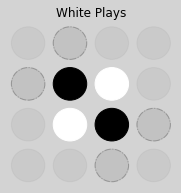

In [8]:
player = 1
display_board(game, board, player, valid_moves=game.getValidMoves(board, player))

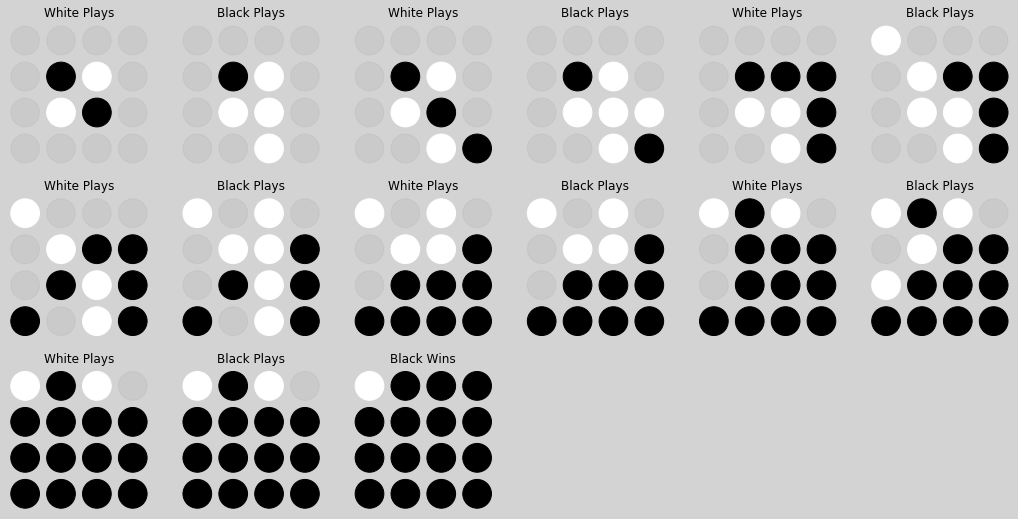

In [9]:
# Grafico episodio
plot_episode(game, states, initial_player = player)

### Interpretación del discounted reward en este caso (Juegos):
- Siempre empieza jugando blanco. Por eso si pierde blanco, el primer discounted reward (último empezando de atras) tiene que ser negativo
- Siempre se alterna (Si no hay movida eso se considera un paso mas). Esto es para asegurar que se puede multiplicar por -1 para el cálculo del discounted reward
- Si el flag de append_last esta en true, tenerlo en cuanta al analizar el último reward (El primero contando de atras)

In [10]:
# Para entender esto bien 
discounted_rewards = get_discounted_rewards(rewards)
print(discounted_rewards)

[-0.87752102  0.88638487 -0.89533825  0.90438208 -0.91351725  0.92274469
 -0.93206535  0.94148015 -0.95099005  0.96059601 -0.970299    0.9801
 -0.99        1.        ]


In [11]:
states_fl = np.array(states).reshape(-1, 16)
for i in range(len(rewards)):
    turn = ['w', 'b'][i%2]
    print(f'juega {turn} con tablero: {states_fl[i]} dada accion: {actions[i]} se evalua: {discounted_rewards[i]}, {rewards[i]}')

juega w con tablero: [ 0  0  0  0  0 -1  1  0  0  1 -1  0  0  0  0  0] dada accion: 14 se evalua: -0.8775210229989678, 0
juega b con tablero: [ 0  0  0  0  0  1 -1  0  0 -1 -1  0  0  0 -1  0] dada accion: 15 se evalua: 0.8863848717161291, 0
juega w con tablero: [ 0  0  0  0  0 -1  1  0  0  1 -1  0  0  0  1 -1] dada accion: 11 se evalua: -0.8953382542587163, 0
juega b con tablero: [ 0  0  0  0  0  1 -1  0  0 -1 -1 -1  0  0 -1  1] dada accion: 7 se evalua: 0.9043820750088043, 0
juega w con tablero: [ 0  0  0  0  0 -1 -1 -1  0  1  1 -1  0  0  1 -1] dada accion: 0 se evalua: -0.9135172474836407, 0
juega b con tablero: [-1  0  0  0  0 -1  1  1  0 -1 -1  1  0  0 -1  1] dada accion: 12 se evalua: 0.92274469442792, 0
juega w con tablero: [ 1  0  0  0  0  1 -1 -1  0 -1  1 -1 -1  0  1 -1] dada accion: 2 se evalua: -0.9320653479069899, 0
juega b con tablero: [-1  0 -1  0  0 -1 -1  1  0  1 -1  1  1  0 -1  1] dada accion: 13 se evalua: 0.9414801494009999, 0
juega w con tablero: [ 1  0  1  0  0  1  

In [12]:
states.shape, actions.shape, discounted_rewards.shape

((15, 4, 4), (14,), (14,))

# Evaluate

In [13]:
# Cargo policies entrenadas con Programación dinámica
from playing_stats import EvaluatePolicy
optimum_policy = np.load('pi_func_only_winner.npy', allow_pickle=True).item()
optimum_V = np.load('Value_func_only_winner.npy', allow_pickle=True).item()
evalPolicy = EvaluatePolicy(optimum_policy)

In [109]:
def evaluate_training(model, episodes = 100, conv=False, player=None, exploit=False):
    if player is None:
        player = evalPolicy.random_player
    player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                    board, 
                                                    {1: player, 
                                                     -1: lambda game, board: play_with_model(model, game, board, conv=conv, exploit=exploit)}, 
                                                    episodes)
    porc = 100.0*player_2_wins/episodes
    return porc

In [146]:
play_with_full_model(model, game, board, conv=conv)

(14, array([-1.6250834], dtype=float32))

In [149]:
def evaluate_training_full(model, episodes = 100, conv=False, player=None, exploit=False):
    def play_with_mod(model, game, board, conv=conv, exploit=exploit):
        action, value = play_with_full_model(model, game, board, conv=conv, exploit=exploit)
        return action
    if player is None:
        player = evalPolicy.random_player
    player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                    board, 
                                                    {1: player, 
                                                     -1: lambda game, board: play_with_mod(model, game, board, conv=conv, exploit=exploit)}, 
                                                    episodes)
    porc = 100.0*player_2_wins/episodes
    return porc

In [150]:
print(evaluate_training_full(model, conv=True, player=None))

51.0


In [110]:
print(evaluate_training(pi_model, conv=True, player=None))
print(evaluate_training(pi_model, conv=True, player=evalPolicy.policy_player))
print(evaluate_training(pi_model, conv=True, player=evalPolicy.greedy_player))

59.0
23.0
57.0


In [113]:
value, predictions = model.predict(board.reshape(1, 4, 4, 1))

In [118]:
from othello_reinforce_helper import play_with_full_model, play_episode_with_value

In [117]:
play_with_full_model(model, game, board, conv=True, return_predictions=True)

(4,
 array([[-0.04425064]], dtype=float32),
 array([0.06696002, 0.05935386, 0.06462424, 0.05830192, 0.06660936,
        0.06409071, 0.06919497, 0.06477831, 0.0578493 , 0.05705011,
        0.062495  , 0.05203232, 0.06792761, 0.0593576 , 0.06217988,
        0.06719473], dtype=float32))

In [129]:
# Juego episodio
player = 1
# La razon por la que le paso board*player es para que la posición de comienzo sea la misma siempre
states, actions, rewards, values, predictions = play_episode_with_value(
    [lambda game, board, return_predictions: play_with_full_model(model, game, board, conv=True, return_predictions=return_predictions), 
     lambda game, board, return_predictions: play_with_full_model(model, game, board, conv=True, return_predictions=return_predictions)], 
    game, board*player, return_actions=True, return_predictions=True, append_last=True)
print('longitud episodio:', len(states))

longitud episodio: 14


# Train

In [24]:
from keras.utils import to_categorical
from keras.layers import Dense
from othello_reinforce_helper import play_episodes, get_value_model_cnn_deep, get_policy_model_softmax_cnn_deep

In [90]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Concatenate, BatchNormalization, Activation, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.initializers import glorot_uniform
from keras.losses import categorical_crossentropy, binary_crossentropy

In [217]:
def one_cnn(lr = 0.001, ce_w=1, mse_w=1, input_shape = [4, 4, 1], do = 0.25, output_shape = 16):
    model = Sequential()
    model.add(Conv2D(16, 2, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, 2, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 2, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(do))

    inp = Input(input_shape)
    x = model(inp)
    x_value = Dense(1, name='value', activation='tanh')(x)
    x_policy = Dense(output_shape, activation='softmax', name='policy')(x)
    full_model = Model(inp, [x_value, x_policy])

    full_model.compile(Adam(lr), loss={'policy': 'categorical_crossentropy', 'value': 'mse'}, 
                       loss_weights={'policy': ce_w, 'value': mse_w})
    return full_model

In [218]:
model = one_cnn()

In [219]:
model.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 4, 4, 1)      0                                            
__________________________________________________________________________________________________
sequential_63 (Sequential)      (None, 64)           10752       input_46[0][0]                   
__________________________________________________________________________________________________
value (Dense)                   (None, 1)            65          sequential_63[1][0]              
__________________________________________________________________________________________________
policy (Dense)                  (None, 16)           1040        sequential_63[1][0]              
Total params: 11,857
Trainable params: 11,633
Non-trainable params: 224
___________________

In [209]:
def paper_cnn(lr=0.001, filters=512, filter_size=3, do=0.3, input_shape = [4, 4, 1], ce_w=1, mse_w=1):
    output_shape = input_shape[0]*input_shape[1]
    inp = Input(input_shape)    
    x = Activation('relu')(BatchNormalization(axis=3)(Conv2D(filters, filter_size, padding='same', use_bias=False)(inp)))         # batch_size  x board_x x board_y x num_channels
    x = Activation('relu')(BatchNormalization(axis=3)(Conv2D(filters, filter_size, padding='same', use_bias=False)(x)))         # batch_size  x board_x x board_y x num_channels
    x = Activation('relu')(BatchNormalization(axis=3)(Conv2D(filters, filter_size, padding='valid', use_bias=False)(x)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
    # x = Activation('relu')(BatchNormalization(axis=3)(Conv2D(filters, filter_size, padding='valid', use_bias=False)(x)))        # batch_size  x (board_x-4) x (board_y-4) x num_channels
    x = Flatten()(x)       
    x = Dropout(do)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024, use_bias=False)(x))))  # batch_size x 1024
    x = Dropout(do)(Activation('relu')(BatchNormalization(axis=1)(Dense(512, use_bias=False)(x))))          # batch_size x 1024
    v = Dense(1, activation='tanh', name='value')(x)                    # batch_size x 1
    pi = Dense(output_shape, activation='softmax', name='policy')(x)   # batch_size x self.action_size


    model = Model(inputs=inp, outputs=[v, pi])
    model.compile(loss=['mean_squared_error', 'categorical_crossentropy'], optimizer=Adam(lr), 
                  loss_weights=[ mse_w, ce_w])
    return model

In [210]:
model = paper_cnn(input_shape = [4, 4, 1])

In [211]:
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           (None, 4, 4, 1)      0                                            
__________________________________________________________________________________________________
conv2d_236 (Conv2D)             (None, 4, 4, 512)    4608        input_42[0][0]                   
__________________________________________________________________________________________________
batch_normalization_258 (BatchN (None, 4, 4, 512)    2048        conv2d_236[0][0]                 
__________________________________________________________________________________________________
activation_258 (Activation)     (None, 4, 4, 512)    0           batch_normalization_258[0][0]    
___________________________________________________________________________________________

In [212]:
model = paper_cnn(lr=0.001, do=dropout)

In [213]:
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 4, 4, 1)      0                                            
__________________________________________________________________________________________________
conv2d_239 (Conv2D)             (None, 4, 4, 512)    4608        input_43[0][0]                   
__________________________________________________________________________________________________
batch_normalization_263 (BatchN (None, 4, 4, 512)    2048        conv2d_239[0][0]                 
__________________________________________________________________________________________________
activation_263 (Activation)     (None, 4, 4, 512)    0           batch_normalization_263[0][0]    
___________________________________________________________________________________________

# Una sola red neuronal

In [ ]:
n_square = game.n**2
dropout = 0.25
model = one_cnn(lr=0.001, do=dropout)
# model = paper_cnn(lr=0.001, do=dropout)
epsilon = 1e-12
losses = []
value_losses = []
policy_losses = []
episodes = 5000
eval_period = 100
conv = True
discounted_rewards_preds=None
for episode in range(episodes):       
    states, actions, rewards, discounted_rewards_preds, predictions = play_episode_with_value(
    [lambda game, board, return_predictions: play_with_full_model(model, game, board, conv=True, return_predictions=return_predictions), 
     lambda game, board, return_predictions: play_with_full_model(model, game, board, conv=True, return_predictions=return_predictions)], 
    game, board*player, return_actions=True, return_predictions=True)
    
    discounted_rewards = get_discounted_rewards(rewards)
    no_move_indexes = (actions != n_square).flatten()
    states = states[no_move_indexes]
    actions = actions[no_move_indexes].reshape(-1, 1)
    discounted_rewards = discounted_rewards[no_move_indexes].reshape(-1, 1)
    discounted_rewards_preds = discounted_rewards_preds[no_move_indexes].reshape(-1, 1)
    
    # Augmentation
    states = np.vstack([states, np.flip(states, axis=[2]), np.flip(states, axis=[1]), np.rot90(states, axes=(1, 2))])
    actions = np.vstack([actions, actions, actions, actions])
    discounted_rewards = np.vstack([discounted_rewards, discounted_rewards, discounted_rewards, discounted_rewards])
    discounted_rewards_preds = np.vstack([discounted_rewards_preds, discounted_rewards_preds, discounted_rewards_preds, discounted_rewards_preds])
    

    x_train = states.reshape(-1, *board.shape, 1)
    
    y_train = to_categorical(actions, 16)*(discounted_rewards - discounted_rewards_preds)

    hist = model.fit(x_train, [discounted_rewards, y_train], epochs=1, verbose=0, batch_size=len(states))
    value_losses.append(hist.history['value_loss'][-1])    
    policy_losses.append(hist.history['policy_loss'][-1])
    losses.append(hist.history['loss'][-1])
    
    if episode%eval_period == 0:
        entropy = np.mean(-np.sum(np.log(predictions+epsilon)*predictions, axis=1)/np.log(16))
        print(f'episode: {episode}, entropy={entropy}, loss={np.mean(losses[-eval_period:])}, policy_loss={np.mean(policy_losses[-eval_period:])}, value_loss={np.mean(value_losses[-eval_period:])}')
        rand_sec = evaluate_training_full(model, episodes=500, conv=conv, player=evalPolicy.random_player)
        pol_sec = evaluate_training_full(model, episodes=100, conv=conv, player=evalPolicy.policy_player)
        rand_sec_ex = evaluate_training_full(model, episodes=500, conv=conv, player=evalPolicy.random_player, exploit=True)
        pol_sec_ex = evaluate_training_full(model, episodes=100, conv=conv, player=evalPolicy.policy_player, exploit=True)
        print(f'Como segundo contra random_player (explore|exploit): {rand_sec} | {rand_sec_ex}')
        print(f'Como segundo contra policy de programación dinámica (explore|exploit): {pol_sec} | {pol_sec_ex}')
        print()
        if (rand_sec_ex == 100) and (pol_sec_ex == 100):
            print('Evaluando con 2000 episodios ...')
            rand_sec_ex = evaluate_training_full(model, episodes=2000, conv=conv, player=evalPolicy.random_player, exploit=True)
            print(rand_sec_ex)
            if rand_sec_ex == 100:
                break

In [169]:
# model.save('pi_v_cnn.hdf5')

# Dos redes neuronales

In [40]:
# model = get_policy_model_softmax(lr=0.001, hidden_layer_neurons=1024)
# model = get_policy_model_softmax_cnn(lr=0.001, filters=1024, filter_size=4)
# model = get_policy_concat_cnns(lr=0.0001)
# model.compile(Adam(lr=0.0001), loss='categorical_crossentropy')
n_square = game.n**2
dropout = 0.25
model = get_policy_model_softmax_cnn_deep(lr=0.001, do=dropout)
model_v = get_value_model_cnn_deep(lr=0.001, do=dropout)
epsilon = 1e-12
losses = []
mse_losses = []
episodes = 5000
eval_period = 100
if type(model.layers[0]) == Dense:
    conv=False
else:
    conv=True
for episode in range(episodes):       
#     states, actions, rewards, predictions = play_episode([lambda game, board, return_predictions: 
#                                                           play_with_model(model, game, board, conv=conv, return_predictions=return_predictions), 
#                                          lambda game, board, return_predictions: 
#                                                           play_with_model(model, game, board, conv=conv, return_predictions=return_predictions)], 
#                                         game, board*player, return_actions=True, return_predictions=True)
    
    states, actions, rewards, predictions = play_episodes(model, game, board, episodes=1, conv=conv)
    discounted_rewards = get_discounted_rewards(rewards)
    no_move_indexes = (actions != n_square).flatten()
    states = states[no_move_indexes]
    actions = actions[no_move_indexes].reshape(-1, 1)
    discounted_rewards = discounted_rewards[no_move_indexes].reshape(-1, 1)
    
    
# Augmentation
    states = np.vstack([states, np.flip(states, axis=[2]), np.flip(states, axis=[1]), np.rot90(states, axes=(1, 2))])
    actions = np.vstack([actions, actions, actions, actions])
    discounted_rewards = np.vstack([discounted_rewards, discounted_rewards, discounted_rewards, discounted_rewards])
    
    if conv:
        x_train = states.reshape(-1, *board.shape, 1)
    else:
        x_train = states.reshape(-1, n_square)
    
    hist = model_v.fit(x_train, discounted_rewards, epochs=1, verbose=0, batch_size=len(states))
    mse_loss = hist.history['loss'][0]
    discounted_rewards_preds = model_v.predict(x_train, verbose=0)
    mse_losses.append(hist.history['loss'][-1])
    
    y_train = to_categorical(actions, 16)*(discounted_rewards - discounted_rewards_preds)
    hist = model.fit(x_train, y_train, verbose=0, batch_size=len(states))
    loss = hist.history['loss'][-1]
    losses.append(loss)
    if episode%eval_period == 0:
        entropy = np.mean(-np.sum(np.log(predictions+epsilon)*predictions, axis=1)/np.log(16))
        print(f'episode: {episode}, entropy={entropy}, loss={np.mean(losses[-eval_period:])}, mse_loss={np.mean(mse_losses[-eval_period:])}')
        rand_sec = evaluate_training(model, episodes=500, conv=conv, player=evalPolicy.random_player)
        pol_sec = evaluate_training(model, episodes=100, conv=conv, player=evalPolicy.policy_player)
        rand_sec_ex = evaluate_training(model, episodes=500, conv=conv, player=evalPolicy.random_player, exploit=True)
        pol_sec_ex = evaluate_training(model, episodes=100, conv=conv, player=evalPolicy.policy_player, exploit=True)
        print(f'Como segundo contra random_player (explore|exploit): {rand_sec} | {rand_sec_ex}')
        print(f'Como segundo contra policy de programación dinámica (explore|exploit): {pol_sec} | {pol_sec_ex}')
        print()
        if (rand_sec_ex == 100) and (pol_sec_ex == 100):
            break
evaluate_training(model, episodes=1000, conv=conv)

episode: 0, entropy=0.9980559945106506, loss=0.33348265290260315, mse_loss=1.9908438920974731
Como segundo contra random_player (explore|exploit): 76.0 | 87.2
Como segundo contra policy de programación dinámica (explore|exploit): 39.0 | 0.0

episode: 100, entropy=0.674159824848175, loss=-0.5062045016512274, mse_loss=0.838305970877409
Como segundo contra random_player (explore|exploit): 91.8 | 90.0
Como segundo contra policy de programación dinámica (explore|exploit): 49.0 | 100.0

episode: 200, entropy=0.4219535291194916, loss=-0.8944651171937585, mse_loss=0.5910024008154869
Como segundo contra random_player (explore|exploit): 92.6 | 94.0
Como segundo contra policy de programación dinámica (explore|exploit): 35.0 | 0.0

episode: 300, entropy=0.41403570771217346, loss=-1.1603146332502365, mse_loss=0.4635821408033371
Como segundo contra random_player (explore|exploit): 93.0 | 91.2
Como segundo contra policy de programación dinámica (explore|exploit): 44.0 | 0.0

episode: 400, entropy=0.3

98.2

In [153]:
evaluate_training_full(model, episodes=1000, conv=conv, exploit=True)

99.7

In [156]:
np.argsort(model.predict(board.reshape(1, 4, 4, 1))[1])

array([[ 1,  4, 11,  9, 14,  6,  5,  2,  8, 10,  7, 13, 12, 15,  3,  0]])

In [51]:
model_v.predict(board.reshape(1, 4, 4, 1))

array([[-0.8784847]], dtype=float32)

In [157]:
next_board = game.getNextState(board, 1, 1)[0]

In [160]:
predictions = model.predict(-1*next_board.reshape(1, 4, 4, 1))[1][0]
idxs = np.argsort(predictions)[::-1]
print(idxs)
print(predictions[idxs])

[ 0 15 13  3 10  8  2 12  6  7  5 14  9 11  1  4]
[9.9352479e-01 4.1640433e-03 1.1359124e-03 4.3462057e-04 2.7160483e-04
 2.1058608e-04 1.0538049e-04 6.5270688e-05 4.9096765e-05 2.1612208e-05
 4.6900063e-06 4.4951253e-06 3.4878506e-06 1.6795934e-06 1.5652084e-06
 1.2051848e-06]


In [62]:
model_v.predict(-1*next_board.reshape(1, 4, 4, 1))

array([[0.7937339]], dtype=float32)

In [82]:
-next_board

array([[ 0, -1,  0,  0],
       [ 0, -1, -1,  0],
       [ 0, -1,  1,  0],
       [ 0,  0,  0,  0]])

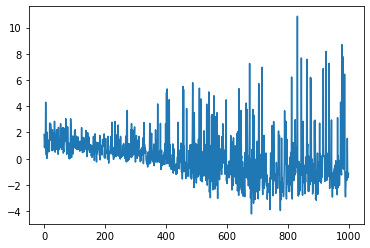

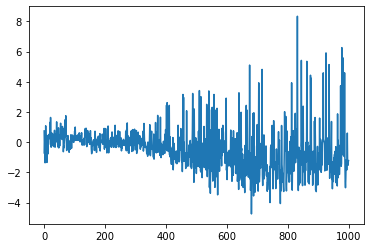

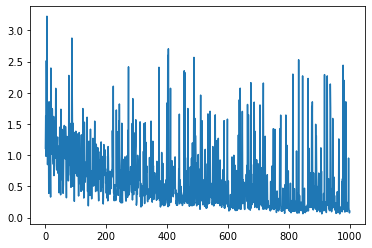

In [164]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()
plt.plot(policy_losses)
plt.show()
plt.plot(value_losses)

In [289]:
from playing_stats import EvaluatePolicy
optimum_policy = np.load('pi_func_only_winner.npy', allow_pickle=True).item()
optimum_V = np.load('Value_func_only_winner.npy', allow_pickle=True).item()
evalPolicy = EvaluatePolicy(optimum_policy)

In [290]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.policy_player, -1: evalPolicy.random_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 84%
player_2 wins: 16%
ties: 0%
Max, Mean, Min margins: 14 3.44 -9
Max, Mean, Min steps: 14 11.7 9
Max, Mean, Min pieces: 16 15.216 12


In [292]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.policy_player, -1: lambda game, board: play_with_model(model, game, board, conv=conv)}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 0%
player_2 wins: 100%
ties: 0%
Max, Mean, Min margins: 2 -5.988 -6
Max, Mean, Min steps: 14 12.77 12
Max, Mean, Min pieces: 16 16.0 16


In [293]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 1000
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: evalPolicy.random_player, -1: lambda game, board: play_with_model(model, game, board, conv=conv, exploit=True)}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 2%
player_2 wins: 98%
ties: 0%
Max, Mean, Min margins: 8 -8.251 -16
Max, Mean, Min steps: 14 9.449 8
Max, Mean, Min pieces: 16 12.509 11


In [295]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 100
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: lambda game, board: play_with_model(model, game, board, conv=conv), -1: evalPolicy.random_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 53%
player_2 wins: 36%
ties: 11%
Max, Mean, Min margins: 16 1.71 -14
Max, Mean, Min steps: 15 12.29 7
Max, Mean, Min pieces: 16 15.57 10


In [297]:
# https://en.wikipedia.org/wiki/Computer_Othello
# Esta demostrado que para 'perfect play', el jugador que juega segundo gana
episodes = 100
player_1_wins, player_2_wins, ties, margins, steps_array, pieces = evalPolicy.get_stats(game, 
                                                board, 
                                                {1: lambda game, board: play_with_model(model, game, board, conv=conv) , -1: evalPolicy.policy_player}, 
                                                episodes)
display_results(player_1_wins, player_2_wins, ties, margins, steps_array, pieces)

player_1 wins: 0%
player_2 wins: 100%
ties: 0%
Max, Mean, Min margins: -2 -5.46 -16
Max, Mean, Min steps: 14 12.77 12
Max, Mean, Min pieces: 16 15.98 15
